In [1]:
import turicreate as tc
import utils
import re
import pandas as pd
from matplotlib import pyplot as plt

### Thinking about this sentiment analysis both are bad, because they have same value as an error, we only can value which one is worse if we put something to do with it. For example, if we want to automatically show in a blog only the positive evaluations about a movie, then the false positives are worse, because there will be negative evaluations in our blog that were predicted as positive. In this case we want to have a high sensitivity, giving recall more importance, then the value of &beta; must be greater than 1, for the sake of this work, let's use 10.

In [2]:
# Transforming data set IMDB csv file in TuriCreate SFrame data
movies_sframe = tc.SFrame('./IMDB_Dataset.csv')
movies_sframe

Finished parsing file /home/tferreirasaraiva/Documents/SupervisedMachineLearning/manning-master/Chapter_6_Logistic_Regression/IMDB_Dataset.csv

Parsing completed. Parsed 100 lines in 0.338911 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 39624 lines. Lines per second: 103492

Finished parsing file /home/tferreirasaraiva/Documents/SupervisedMachineLearning/manning-master/Chapter_6_Logistic_Regression/IMDB_Dataset.csv

Parsing completed. Parsed 50000 lines in 0.436552 secs.

review,sentiment
One of the otherreviewers has mentioned ...,positive
A wonderful littleproduction. <br /><br ...,positive
I thought this was awonderful way to spend ...,positive
Basically there's afamily where a little ...,negative
"Petter Mattei's ""Love inthe Time of Money"" is a ...",positive
"Probably my all-timefavorite movie, a story ...",positive
I sure would like to seea resurrection of a up ...,positive
"This show was an amazing,fresh & innovative idea ...",negative
Encouraged by thepositive comments about ...,negative
If you like original gutwrenching laughter you ...,positive


In [3]:
# Function used to clean the text
def clean_text(text):
    """
    function to clean a text using regex removing HTML tags, numbers, backslashs,
    punctuation, finding white spaces and replacing them with only one white space,
    removing words with one and two characters, and some common words that won't 
    make much impact in the sentiment analysis.
    """
    
    # Lowering every word in the text
    text = text.lower()
    # Creating a list of common stop words in english
    stopwords = [
                 'that', 'this', 'with', 'than', 'the', 'and', 'for', 'are'
                 'you', 'her', 'our', 'his', 'was', 'from', 'they', 'there'
                ]
    # Iterating over each word then excluding stop words that matchs the list
    for words in stopwords:
        text = re.sub('\\b' + words + '\\b', '', text)
    # Excluding HTML tags    
    text = re.sub('<.*>', '', text)
    # Removing numbers
    text = re.sub('\d', '', text)
    # Removing backslashs
    text = re.sub('\\\\', '', text)
    # Removing words with only two characters
    text = re.sub('\\b\w{1,2}\\b', '', text)
    # Removing punctuation
    text = re.sub('[^\w^\s\n]', '', text)
    # Removing extra white spaces
    text = re.sub('\s+', ' ', text)
    
    # Returning the text that was cleaned
    return text

In [4]:
# Getting the reviews from the data frame, then applying a function to clean word by word in the review column
movies_sframe['review'] = movies_sframe.apply(lambda x: clean_text(x['review']))

In [5]:
movies_sframe['review']

dtype: str
Rows: 50000
['one other reviewers has mentioned after watching just episode you hooked are right exactly what happened would say main appeal show due fact goes where other shows wouldn dare forget pretty pictures painted mainstream audiences forget charm forget romance doesn mess around first episode ever saw struck nasty surreal couldn say ready but watched more developed taste got accustomed high levels graphic violence not just violence but injustice crooked guards who sold out nickel inmates who kill order get away well mannered middle class inmates being turned into prison bitches due their lack street skills prison experience watching you may become comfortable what uncomfortable viewingthats you can get touch your darker side', ' wonderful little production realism really comes home little things fantasy guard which rather use traditional dream techniques remains solid then disappears plays knowledge senses particularly scenes concerning orton halliwell sets particula

In [6]:
# Making a new data frame, inserting cleaned review column
movies = tc.SFrame(movies_sframe)
# Creating a new column called words with Turi Create text analytics method, to counting each word in review column
movies['words'] = tc.text_analytics.count_words(movies['review'])
movies

review,sentiment,words
one other reviewers hasmentioned after watching ...,positive,"{'comfortable': 1.0,'street': 1.0, 'their': ..."
wonderful littleproduction realism re ...,positive,"{'done': 1.0, 'well':1.0, 'are': 1.0, ..."
thought wonderful wayspend time too hot su ...,positive,"{'see': 1.0, 'superman':1.0, 'interesting': 1.0, ..."
basically family wherelittle boy jake thinks ...,negative,"{'them': 1.0, 'shots':1.0, 'descent': 1.0, ..."
petter mattei love timemoney visually stunning ...,positive,"{'anxiously': 1.0,'await': 1.0, 'work': ..."
probably alltime favoritemovie story selflessness ...,positive,"{'all': 1.0, 'thumbs':1.0, 'dozen': 1.0, ..."
sure would like seeresurrection dated ...,positive,"{'then': 1.0, 'doubt':1.0, 'out': 1.0, 'lin ..."
show amazing freshinnovative idea when ...,negative,"{'awful': 1.0, 'just':1.0, 'now': 1.0, ..."
encouraged positivecomments about film here ...,negative,"{'obsessives': 1.0,'effort': 1.0, 'bit': ..."
you like original gutwrenching laughter you ...,positive,"{'mom': 1.0, 'hell': 1.0,'great': 1.0, 'love': ..."


In [7]:
# Splitting data into 80% to training data, resting 20% of it
train_data, rest_data = movies.random_split(0.8, seed=0)
# From the 20% that remained splitting it into halves, so from the rest 10% goes for testing, 10% for validation
test_data, validation_data = rest_data.random_split(0.5, seed=0)

In [8]:
# Creating a logistic classifier model, called model, using movies as data, column words as feature and
# considering sentiment as label
model = tc.logistic_classifier.create(
                                      movies, 
                                      features=['words'], 
                                      target='sentiment', 
                                      validation_set=validation_data
                                     )

Logistic regression:

--------------------------------------------------------

Number of examples          : 50000

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 114328

Number of coefficients      : 114329

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 1.167120     | 0.935040          | 0.932960            |

| 1         | 4        | 1.000000  | 1.349351     | 0.971180          | 0.970382            |

| 2         | 5        | 1.000000  | 1.434909     | 0.981540          | 0.980788            |

| 3         | 6        | 1.000000  | 1.544558     | 0.984400          | 0.982590            |

| 4         | 8        | 1.000000  | 1.682997     | 0.989560          | 0.989594            |

| 9         | 13       | 1.000000  | 2.069737     | 0.997120          | 0.995597            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [9]:
# Creating another logistic classifier model, called model hyperparameters, 
# using movies as data, column words as feature and considering sentiment as label
# also using hyperparameters to refine the model
model_hyperparameters = tc.logistic_classifier.create(
                                                      movies, 
                                                      features=['words'], 
                                                      target='sentiment', 
                                                      validation_set=validation_data, 
                                                      # feature_rescaling=False,
                                                      l1_penalty=1, 
                                                      l2_penalty=100,
                                                      # max_iterations=200  
                                                     )

Logistic regression:

--------------------------------------------------------

Number of examples          : 50000

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 114328

Number of coefficients      : 114329

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 1        | 1.000000  | 0.093427     | 0.500000          | 0.495497            |

| 1         | 2        | 0.000008  | 1.449042     | 0.934960          | 0.932560            |

| 2         | 3        | 0.000008  | 1.619168     | 0.959380          | 0.957174            |

| 3         | 4        | 0.000008  | 1.791236     | 0.964100          | 0.963778            |

| 4         | 5        | 0.000003  | 2.022024     | 0.973200          | 0.971783            |

| 5         | 6        | 0.000003  | 2.189081     | 0.975580          | 0.974785            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

In [10]:
# Evaluating accuracy of model training data with TuriCreate features
train_accuracy = model.evaluate(train_data)['accuracy']
# Evaluating accuracy of model validation data with TuriCreate features
validation_accuracy = model.evaluate(validation_data)['accuracy']
print("Training accuracy for model:", train_accuracy)
print("Validation accuracy for model:", validation_accuracy)

Training accuracy for model: 0.9973021582733813
Validation accuracy for model: 0.995597358415049


In [11]:
# Evaluating accuracy of hyperparameter model training data with TuriCreate
train_accuracy = model_hyperparameters.evaluate(train_data)['accuracy']
# Evaluating accuracy of hyperparameter model validation data with TuriCreate
validation_accuracy = model_hyperparameters.evaluate(validation_data)['accuracy']
print("Training accuracy for model:", train_accuracy)
print("Validation accuracy for model:", validation_accuracy)

Training accuracy for model: 0.9759192645883293
Validation accuracy for model: 0.9747848709225535


In [12]:
# Using TuriCreate to evaluate model validation data confusion matrix
confusion_matrix = model.evaluate(validation_data)['confusion_matrix']
print(confusion_matrix)

+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|   negative   |     positive    |   17  |
|   positive   |     negative    |   5   |
|   positive   |     positive    |  2471 |
|   negative   |     negative    |  2504 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



In [13]:
# Using TuriCreate to evaluate hyperparameters model validation data confusion matrix
confusion_matrix_hyper = model_hyperparameters.evaluate(validation_data)['confusion_matrix']
print(confusion_matrix_hyper)

+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|   negative   |     positive    |   70  |
|   positive   |     negative    |   56  |
|   positive   |     positive    |  2420 |
|   negative   |     negative    |  2451 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



In [14]:
# Creating a variable with model evaluation
evalueted = model.evaluate(movies)
# Getting precision from the evaluated results
precision = evalueted['precision']
# Then getting recall from evaluated results
recall = evalueted['recall']
print('model precision:', precision)
print('model recall:', recall)

model precision: 0.9970404735242361
model recall: 0.9972


In [15]:
# Giving a value to beta
b = 10
# Calculating the Fbeta score with the formula, using stored values of precision and recall
f = (1 + b**2) * (precision * recall) / ((b**2 * precision) + recall)
f

0.9971984202797302

In [16]:
# Creating a variable with hyperparameter model evaluation
evalueted_hyper = model_hyperparameters.evaluate(movies)
# Getting precision from the evaluated results
precision_hyper = evalueted_hyper['precision']
# Then getting recall from evaluated results
recall_hyper = evalueted_hyper['recall']
print('hyper model precision:', precision_hyper)
print('hyper model recall:', recall_hyper)

hyper model precision: 0.975941715703935
hyper model recall: 0.9752


In [17]:
# Giving a value to beta
b = 10
# Calculating the Fbeta score with the formula, using stored values of precision and recall
f_hyper = (1 + b**2) * (precision_hyper * recall_hyper) / ((b**2 * precision_hyper) + recall_hyper)
f_hyper

0.9752073381938319

In [18]:
# Storing predictions from model with probability output, this variable is used to calculate the ROC
predictions = model.predict(movies, output_type='probability')
# Storing predictions from hyperparameter model with probability output, this variable is used to calculate the ROC
predictions_hyper = model_hyperparameters.predict(movies, output_type='probability')

In [19]:
# Calculating the ROC from the model, then printing first and last 10 thresholds
roc_data =  tc.evaluation.roc_curve(movies['sentiment'], predictions)
display(roc_data.head())
display(roc_data.tail())

threshold,fpr,tpr,p,n
0.0,1.0,1.0,25000,25000
0.001,0.13568,1.0,25000,25000
0.002,0.10732,1.0,25000,25000
0.003,0.094,1.0,25000,25000
0.004,0.08372,1.0,25000,25000
0.005,0.07624,1.0,25000,25000
0.006,0.07024,1.0,25000,25000
0.007,0.06592,1.0,25000,25000
0.008,0.06172,1.0,25000,25000
0.009,0.0586,1.0,25000,25000


threshold,fpr,tpr,p,n
0.991,0.0,0.92268,25000,25000
0.992,0.0,0.91724,25000,25000
0.993,0.0,0.91132,25000,25000
0.994,0.0,0.90376,25000,25000
0.995,0.0,0.8944,25000,25000
0.996,0.0,0.88272,25000,25000
0.997,0.0,0.86592,25000,25000
0.998,0.0,0.83988,25000,25000
0.999,0.0,0.78936,25000,25000
1.0,0.0,0.0,25000,25000


In [20]:
# Calculating the ROC from the hyperparamter model, then printing first and last 10 thresholds
roc_data_hyper =  tc.evaluation.roc_curve(movies['sentiment'], predictions_hyper)
display(roc_data_hyper.head())
display(roc_data_hyper.tail())

threshold,fpr,tpr,p,n
0.0,1.0,1.0,25000,25000
0.001,0.99108,1.0,25000,25000
0.002,0.98584,1.0,25000,25000
0.003,0.98004,1.0,25000,25000
0.004,0.97444,1.0,25000,25000
0.005,0.97,1.0,25000,25000
0.006,0.96604,1.0,25000,25000
0.007,0.96092,1.0,25000,25000
0.008,0.95596,1.0,25000,25000
0.009,0.95172,1.0,25000,25000


threshold,fpr,tpr,p,n
0.991,0.0,0.05344,25000,25000
0.992,0.0,0.0486,25000,25000
0.993,0.0,0.04432,25000,25000
0.994,0.0,0.03924,25000,25000
0.995,0.0,0.03456,25000,25000
0.996,0.0,0.0288,25000,25000
0.997,0.0,0.024,25000,25000
0.998,0.0,0.01828,25000,25000
0.999,0.0,0.01204,25000,25000
1.0,0.0,0.0,25000,25000


In [21]:
# Using calculated ROC to make to lists of values, one for TPR and other for FPR, with model predictions
roc_x = roc_data['tpr']
roc_y = 1 - roc_data['fpr']

In [22]:
# Using calculated ROC to make to lists of values, one for TPR and other for FPR, with hyperparameter model
roc_x_hyper = roc_data_hyper['tpr']
roc_y_hyper = 1 - roc_data_hyper['fpr']

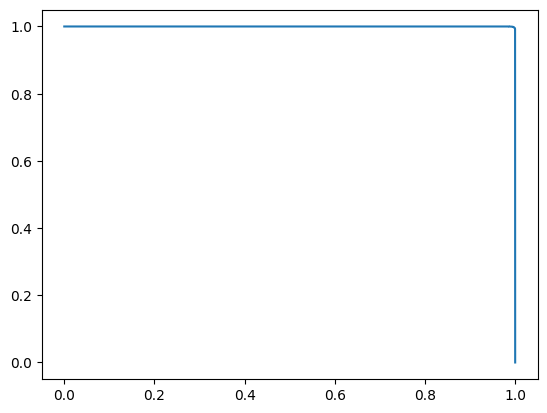

In [23]:
# Given TPR list and FPR list, plot a graph with them, model
plt.plot(roc_x, roc_y)

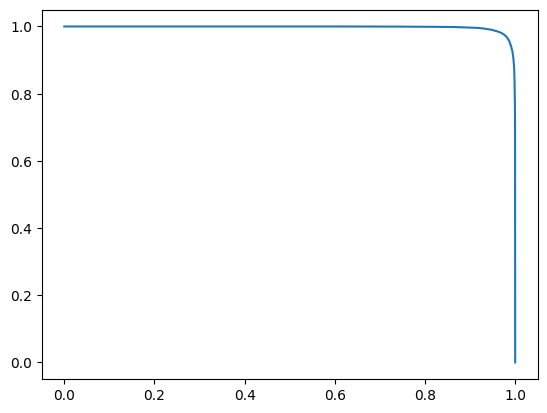

In [24]:
# Given TPR list and FPR list, plot a graph with them, hyperparameter model
plt.plot(roc_x_hyper, roc_y_hyper)

In [25]:
# Calculate the area under the curve for the model
auc =  tc.evaluation.auc(movies['sentiment'], predictions)
auc

0.9999768608000003

In [26]:
# Calculate the area under the curve for the hyperparameter model
auc_hyper =  tc.evaluation.auc(movies['sentiment'], predictions_hyper)
auc_hyper

0.9974649272000004

### Both models had quite similar results, but we can see by the results that the model performs a bit better than hyperparameters model. The confusion matrix gives it clearly because false positives and false negatives values are slightly lower in the model. 

In [31]:
# Evaluating the testing accuracy from the splitted test data, to compare with model's results
test_accuracy = model.evaluate(test_data)['accuracy']
print("Test accuracy:", test_accuracy)

Test accuracy: 0.9971836652584993


In [32]:
# Creating a confusion matrix from the test data
confusion_matrix_test = model.evaluate(test_data)['confusion_matrix']
print(confusion_matrix_test)

+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|   negative   |     negative    |  2491 |
|   positive   |     positive    |  2466 |
|   positive   |     negative    |   6   |
|   negative   |     positive    |   8   |
+--------------+-----------------+-------+
[4 rows x 3 columns]



In [29]:
# Creating a testing data evaluation, for the model
test_model = model.evaluate(test_data)
# Getting the model precision for the test data
test_precision = test_model['precision']
# Getting the model recall for the test data
test_recall = test_model['recall']
print('Precision test data:', test_precision)
print('Recall test data:', test_recall)

Precision test data: 0.9967663702506063
Recall test data: 0.9975728155339806


In [30]:
# Giving beta a value to calculate the Fbeta score
b = 10
# Using test data precision and recall to calculate the Fbeta score
f_test = (1 + b**2) * (test_precision * test_recall) / ((b**2 * test_precision) + test_recall)
f_test

0.9975648245311887